# 1. Predicting Life Expectancy - Exploratory Data Analysis (EDA)

EDA offers a chance to become acquainted with the dataset at hand. This process involves identifying various features, checking for missing values, and assessing the data's overall quality. Throughout this article, I'll use the term 'features' interchangeably with 'variables'. Feel free to use whichever term you're more comfortable with.

This Jupyter notebook contains an exploratory data analysis (EDA) of a dataset related to life expectancy, using World Health Organisation (WHO) data sourced from Kaggle:
https://www.kaggle.com/datasets/kumarajarshi/life-expectancy-who?resource=download

The context of the EDA is to prepare tfor building a regression model to predict life expectancy using the provided features. 

The purpose of this EDA is to understand the data's structure, check for missing and incorrect values, and explore relationships between different variables.

The notebook is structured as follows:

1. **Data Loading**
2. **Understanding Data Structure**
3. **Categorising Features**
4. **Identifying Key Features**
5. **Assessing Data Quality**
6. **Univariate Analysis - Understanding individual features**: 
7. **Bivariate Analysis - Understanding relationships between features**

For more info on exploratory data analysis, see:
https://medium.com/@h.jurza/unveiling-hidden-insights-a-quick-start-guide-to-exploratory-data-analysis-eda-c843dd710726

# Import packages

In [2]:
# General packages
import pandas as pd
import numpy as np

# Pre-processing and modeling packages
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import statsmodels.api as sm

# Plotting packages
import seaborn as sns
import matplotlib.pyplot as plt

# Define Useful Functions

In [3]:
def describe_categorical(df):
    """
    Generates a summary DataFrame for categorical columns in the given DataFrame.

    Parameters:
    - df: A pandas DataFrame.

    Returns:
    - A pandas DataFrame summarizing the categorical columns, including count of non-null values,
      number of unique values, most frequent category, and frequency of the most frequent category.
    """
    # Identify categorical columns by dtype 'object' or 'category'
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns

    # Initialize an empty dictionary to hold summary data
    summary_data = {
        'Column': [],
        'Count': [],
        'Unique': [],
        'Top': [],
        'Freq': []
    }

    # Loop through each categorical column to calculate summary statistics
    for col in categorical_columns:
        summary_data['Column'].append(col)
        summary_data['Count'].append(df[col].notnull().sum())  # Count of non-null values
        summary_data['Unique'].append(df[col].nunique())  # Number of unique values
        top_value = df[col].mode()[0]  # Most frequent category
        summary_data['Top'].append(top_value)
        summary_data['Freq'].append(df[df[col] == top_value].shape[0])  # Frequency of the top category

    # Convert the summary dictionary into a DataFrame
    summary_df = pd.DataFrame(summary_data)

    # Set the 'Column' as the index for better readability
    summary_df.set_index('Column', inplace=True)

    return summary_df

def format_dataframe_columns(df_in):
    """formats dataframe column names by removing spaces, special characters and makes lowercase"""

    import re

    def rename_col(old_col):
        # Make column str type and strip training and leading whitespace
        new_col = str(old_col).strip() 

        # Replace multiple spaces with a single space
        new_col = re.sub(r'\s+', ' ', new_col)

        # Replace spaces, hyphens and slashes with underscore
        new_col = new_col.replace(' ','_')
        new_col = new_col.replace('-','_')
        new_col = new_col.replace('/','_')
        new_col = new_col.replace('\\','_')

        # Remove special characters
        new_col = re.sub(r'[?*!&()]', '', new_col)

        # Make all lowercase
        new_col = new_col.lower()

        return new_col

    df_out = df_in.copy()

    # Get list of dataframe columns
    df_cols_old = df_out.columns

    # Make list of new col names, then put into replacement dict
    df_cols_new = [rename_col(old_col) for old_col in df_cols_old]
    replacement_dict = dict(zip(df_cols_old, df_cols_new))

    # Rename df cols with new col names
    df_out = df_out.rename(columns=(replacement_dict))

    return df_out

# Read Data

In [54]:
# Read data
df = pd.read_csv('data/Life Expectancy Data.csv')

# Format dataframe columns to be lowercase and separated by underscores (for visual consistency)
df = format_dataframe_columns(df)

# 1. Understanding the Data Structure
Initially, we examine our data's structure at a macro level, including the count of observations and features, their types, and their organisation.


In [55]:
# Display basic info on fields within dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   country                          2938 non-null   object 
 1   year                             2938 non-null   int64  
 2   status                           2938 non-null   object 
 3   life_expectancy                  2928 non-null   float64
 4   adult_mortality                  2928 non-null   float64
 5   infant_deaths                    2938 non-null   int64  
 6   alcohol                          2744 non-null   float64
 7   percentage_expenditure           2938 non-null   float64
 8   hepatitis_b                      2385 non-null   float64
 9   measles                          2938 non-null   int64  
 10  bmi                              2904 non-null   float64
 11  under_five_deaths                2938 non-null   int64  
 12  polio               

In [56]:
# Display first few rows of the dataframe
df.head()

country  year      status  life_expectancy  adult_mortality  \
0  Afghanistan  2015  Developing             65.0            263.0   
1  Afghanistan  2014  Developing             59.9            271.0   
2  Afghanistan  2013  Developing             59.9            268.0   
3  Afghanistan  2012  Developing             59.5            272.0   
4  Afghanistan  2011  Developing             59.2            275.0   

   infant_deaths  alcohol  percentage_expenditure  hepatitis_b  measles  ...  \
0             62     0.01               71.279624         65.0     1154  ...   
1             64     0.01               73.523582         62.0      492  ...   
2             66     0.01               73.219243         64.0      430  ...   
3             69     0.01               78.184215         67.0     2787  ...   
4             71     0.01                7.097109         68.0     3013  ...   

   polio  total_expenditure  diphtheria  hiv_aids         gdp  population  \
0    6.0               8.16        65.0       0.1  584.259210  33736494.0   
1   58.0               8.18        62.0       0.1  612.696514    327582.0   
2   62.0               8.13        64.0       0.1  631.744976  31731688.0   
3   67.0               8.52        67.0       0.1  669.959000   3696958.0   
4   68.0               7.87        68.0       0.1   63.537231   2978599.0   

   thinness_1_19_years  thinness_5_9_years  income_composition_of_resources  \
0                 17.2                17.3                            0.479   
1                 17.5                17.5                            0.476   
2                 17.7                17.7                            0.470   
3                 17.9                18.0                            0.463   
4                 18.2                18.2                            0.454   

   schooling  
0       10.1  
1       10.0  
2        9.9  
3        9.8  
4        9.5  

[5 rows x 22 columns]

# 2. Categorising Features
We then categorise our features, which aids in determining our approach to visualisation and processing. Features can be categorised as:

- **Categorical**: These include a finite set of categories and can be either nominal or ordinal.
- **Continuous**: Numerical data that can take an infinite range of values.
- **Other**: Some features, such as free text, are technically categorical but might be treated as individual values rather than as members of a category.

This is an good time to examine data types. For instance, an ordinal categorical feature represented by numbers should be treated as an integer rather than a float. Similarly, numeric data in a string or character field warrants attention.

In [57]:
# Identify numeric and categorical fields (save to a list of field names for each)
num_vars = df.select_dtypes(include=['float64', 'int64']).columns
cat_vars = df.select_dtypes(include=['object']).columns

In [58]:
# View a categorical fields of the dataframe to make sure the data types are correct
df[cat_vars]

country      status
0     Afghanistan  Developing
1     Afghanistan  Developing
2     Afghanistan  Developing
3     Afghanistan  Developing
4     Afghanistan  Developing
...           ...         ...
2933     Zimbabwe  Developing
2934     Zimbabwe  Developing
2935     Zimbabwe  Developing
2936     Zimbabwe  Developing
2937     Zimbabwe  Developing

[2938 rows x 2 columns]

In [59]:
# View a numeric fields of the dataframe to make sure the data types are correct
df[num_vars]

year  life_expectancy  adult_mortality  infant_deaths  alcohol  \
0     2015             65.0            263.0             62     0.01   
1     2014             59.9            271.0             64     0.01   
2     2013             59.9            268.0             66     0.01   
3     2012             59.5            272.0             69     0.01   
4     2011             59.2            275.0             71     0.01   
...    ...              ...              ...            ...      ...   
2933  2004             44.3            723.0             27     4.36   
2934  2003             44.5            715.0             26     4.06   
2935  2002             44.8             73.0             25     4.43   
2936  2001             45.3            686.0             25     1.72   
2937  2000             46.0            665.0             24     1.68   

      percentage_expenditure  hepatitis_b  measles   bmi  under_five_deaths  \
0                  71.279624         65.0     1154  19.1                 83   
1                  73.523582         62.0      492  18.6                 86   
2                  73.219243         64.0      430  18.1                 89   
3                  78.184215         67.0     2787  17.6                 93   
4                   7.097109         68.0     3013  17.2                 97   
...                      ...          ...      ...   ...                ...   
2933                0.000000         68.0       31  27.1                 42   
2934                0.000000          7.0      998  26.7                 41   
2935                0.000000         73.0      304  26.3                 40   
2936                0.000000         76.0      529  25.9                 39   
2937                0.000000         79.0     1483  25.5                 39   

      polio  total_expenditure  diphtheria  hiv_aids         gdp  population  \
0       6.0               8.16        65.0       0.1  584.259210  33736494.0   
1      58.0               8.18        62.0       0.1  612.696514    327582.0   
2      62.0               8.13        64.0       0.1  631.744976  31731688.0   
3      67.0               8.52        67.0       0.1  669.959000   3696958.0   
4      68.0               7.87        68.0       0.1   63.537231   2978599.0   
...     ...                ...         ...       ...         ...         ...   
2933   67.0               7.13        65.0      33.6  454.366654  12777511.0   
2934    7.0               6.52        68.0      36.7  453.351155  12633897.0   
2935   73.0               6.53        71.0      39.8   57.348340    125525.0   
2936   76.0               6.16        75.0      42.1  548.587312  12366165.0   
2937   78.0               7.10        78.0      43.5  547.358878  12222251.0   

      thinness_1_19_years  thinness_5_9_years  \
0                    17.2                17.3   
1                    17.5                17.5   
2                    17.7                17.7   
3                    17.9                18.0   
4                    18.2                18.2   
...                   ...                 ...   
2933                  9.4                 9.4   
2934                  9.8                 9.9   
2935                  1.2                 1.3   
2936                  1.6                 1.7   
2937                 11.0                11.2   

      income_composition_of_resources  schooling  
0                               0.479       10.1  
1                               0.476       10.0  
2                               0.470        9.9  
3                               0.463        9.8  
4                               0.454        9.5  
...                               ...        ...  
2933                            0.407        9.2  
2934                            0.418        9.5  
2935                            0.427       10.0  
2936                            0.427        9.8  
2937                            0.434        9.8  

[2938 rows x 20 columns]

### Convert any variables with incorrect data types

**Converting 'year' from Numeric to Categorical**

The 'year' field in our dataset is currently treated as a numeric variable. However, 'year' is more appropriately treated as a categorical variable  (unless you are doing time series analysis), as it represents distinct periods rather than a continuous quantity.

In [60]:
# Convert the 'year' field from numeric to categorical
df['year'] = df['year'].astype('category')


# Update our categrical and numeric variable lists as we will use them later
num_vars = df.select_dtypes(include=['float64', 'int64']).columns
cat_vars = df.select_dtypes(include=['object']).columns

# 3. Identifying Key Features
After understanding our feature types, we identify the key features. Our problem formulation and the business problem can guide this process.

A similar process is used for regression or for supervised learning (when trying to predict a specific value in labeled data). This requires us to identify our 'target' and 'features'.

***Target***

In a supervised machine learning approach, we need to determine our dependent variable. This feature represents the outcome we aim to predict.
- also known as 'target' variable in machine learning
- sometimes also known as 'response variable'

in Machine learning, we call this a target vector as it is typically a **1 dimensional array** or single column of data.

In this case, 'life_expectancy' is our target. 


***Features***

All other variables will be used as inputs to the modelling and treated as 'independent variables'
- also known as 'features' in machine learning
- also known as 'predictors' or 'explanatory variables'

in machine learning we call this is a feature matrix, as it is typically a **multi-dimensional array** or  multiple columns of data

We can use all of these, or select specific features to include (based on domain understanding or model performance). This is where some experimentation comes in , but we'll get to that later.



For example:

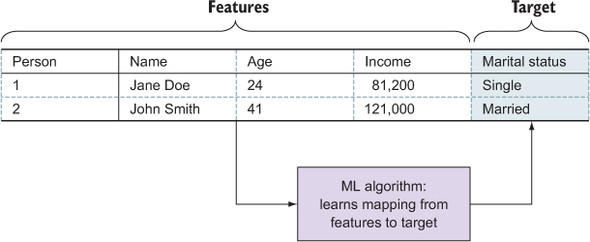


In [61]:
# Preview our target vector
df['life_expectancy']

0       65.0
1       59.9
2       59.9
3       59.5
4       59.2
        ... 
2933    44.3
2934    44.5
2935    44.8
2936    45.3
2937    46.0
Name: life_expectancy, Length: 2938, dtype: float64

# 4. Assessing Data Quality

Before proceeding with analysis, we should assess the quality of our data. This involves identifying missing values in each field and considering how to handle them during data pre-processing. Many machine learning models cannot handle missing values, making this step essential.

Understanding why data is missing can also provide insights. It could be due to issues in the data collection process, which might be avoidable in future data collection efforts. By addressing these issues, we can improve the quality of our data and, consequently, the performance of our models.

### 4.1 Identifying missing values
First we check how many missing values there are in each column

In [62]:
# Check for missing values in the DataFrame
missing_values = df.isnull().sum()

# Display the number of missing values in each column
missing_values

country                              0
year                                 0
status                               0
life_expectancy                     10
adult_mortality                     10
infant_deaths                        0
alcohol                            194
percentage_expenditure               0
hepatitis_b                        553
measles                              0
bmi                                 34
under_five_deaths                    0
polio                               19
total_expenditure                  226
diphtheria                          19
hiv_aids                             0
gdp                                448
population                         652
thinness_1_19_years                 34
thinness_5_9_years                  34
income_composition_of_resources    167
schooling                          163
dtype: int64

### 4.2 Imputing Missing Values

Missing values in our dataset can be problematic as many machine learning models cannot handle them. To address this, we can impute, or fill in, these missing values.

In our example: 
- For numerical data, we use the mean value. 
- For categorical data, we use the most frequent category to impute missing values (there are none in this data, but this is a common simple method). 

This is done using the `SimpleImputer` class from `sklearn.impute`.

It's important to note that there are many other imputation methods available, each with their own strengths and weaknesses. The choice of imputation method should be guided by the nature of the data and the specific requirements of your analysis.

For more info see: https://medium.com/@h.jurza/missing-data-no-problem-techniques-for-handling-incomplete-datasets-2a1e48118445

In [63]:
# Create an imputer for categorical data
cat_imputer = SimpleImputer(strategy='most_frequent')

# Impute missing values in categorical columns
df[cat_vars] = cat_imputer.fit_transform(df[cat_vars])

# Create an imputer for numerical data
num_imputer = SimpleImputer(strategy='mean')

# Impute missing values in numerical columns
df[num_vars] = num_imputer.fit_transform(df[num_vars])

# 5. Understanding individual features (Univariate Analysis)
Once we understand what features we have in the data and have an idea of how we might deal with them, we can start looking at the shape of the data they contain.

One of the primary tools we will be using is visualisation. EDA often involves creating visualisations of the data to help identify patterns and relationships that may not be immediately apparent. Visualisations can help identify correlations between variables, trends over time and help identify potential outliers.m

In [64]:
# Summary statistics for numerical features
df.describe()

life_expectancy  adult_mortality  infant_deaths      alcohol  \
count      2938.000000      2938.000000    2938.000000  2938.000000   
mean         69.224932       164.796448      30.303948     4.602861   
std           9.507640       124.080302     117.926501     3.916288   
min          36.300000         1.000000       0.000000     0.010000   
25%          63.200000        74.000000       0.000000     1.092500   
50%          72.000000       144.000000       3.000000     4.160000   
75%          75.600000       227.000000      22.000000     7.390000   
max          89.000000       723.000000    1800.000000    17.870000   

       percentage_expenditure  hepatitis_b        measles          bmi  \
count             2938.000000  2938.000000    2938.000000  2938.000000   
mean               738.251295    80.940461    2419.592240    38.321247   
std               1987.914858    22.586855   11467.272489    19.927677   
min                  0.000000     1.000000       0.000000     1.000000   
25%                  4.685343    80.940461       0.000000    19.400000   
50%                 64.912906    87.000000      17.000000    43.000000   
75%                441.534144    96.000000     360.250000    56.100000   
max              19479.911610    99.000000  212183.000000    87.300000   

       under_five_deaths        polio  total_expenditure   diphtheria  \
count        2938.000000  2938.000000        2938.000000  2938.000000   
mean           42.035739    82.550188           5.938190    82.324084   
std           160.445548    23.352143           2.400274    23.640073   
min             0.000000     3.000000           0.370000     2.000000   
25%             0.000000    78.000000           4.370000    78.000000   
50%             4.000000    93.000000           5.938190    93.000000   
75%            28.000000    97.000000           7.330000    97.000000   
max          2500.000000    99.000000          17.600000    99.000000   

          hiv_aids            gdp    population  thinness_1_19_years  \
count  2938.000000    2938.000000  2.938000e+03          2938.000000   
mean      1.742103    7483.158469  1.275338e+07             4.839704   
std       5.077785   13136.800417  5.381546e+07             4.394535   
min       0.100000       1.681350  3.400000e+01             0.100000   
25%       0.100000     580.486996  4.189172e+05             1.600000   
50%       0.100000    3116.561755  3.675929e+06             3.400000   
75%       0.800000    7483.158469  1.275338e+07             7.100000   
max      50.600000  119172.741800  1.293859e+09            27.700000   

       thinness_5_9_years  income_composition_of_resources    schooling  
count         2938.000000                      2938.000000  2938.000000  
mean             4.870317                         0.627551    11.992793  
std              4.482708                         0.204820     3.264381  
min              0.100000                         0.000000     0.000000  
25%              1.600000                         0.504250    10.300000  
50%              3.400000                         0.662000    12.100000  
75%              7.200000                         0.772000    14.100000  
max             28.600000                         0.948000    20.700000

In [65]:
# Summary of categorical features 
# Here we call one of our own functions defined 
# above for summarising categorical features

describe_categorical(df)

Count  Unique          Top  Freq
Column                                   
country   2938     193  Afghanistan    16
year      2938      16         2013   193
status    2938       2   Developing  2426

### 5.1 Plot distribution of target variable

In this analysis, our target variable is 'life_expectancy'. Understanding the distribution of the target variable is a crucial step in any data analysis or machine learning project for several reasons:

1. **Outliers**: The distribution helps identify outliers that may impact our model's performance.
2. **Data Characteristics**: It reveals if most life expectancy values are around the mean (normal distribution) or skewed to one side.
3. **Model Selection**: Some models assume a normally distributed target variable. If 'life_expectancy' isn't, we may need to adjust our model selection or data transformation.
4. **Performance Expectations**: High variability in 'life_expectancy' could make accurate predictions more challenging, helping set realistic model performance expectations.

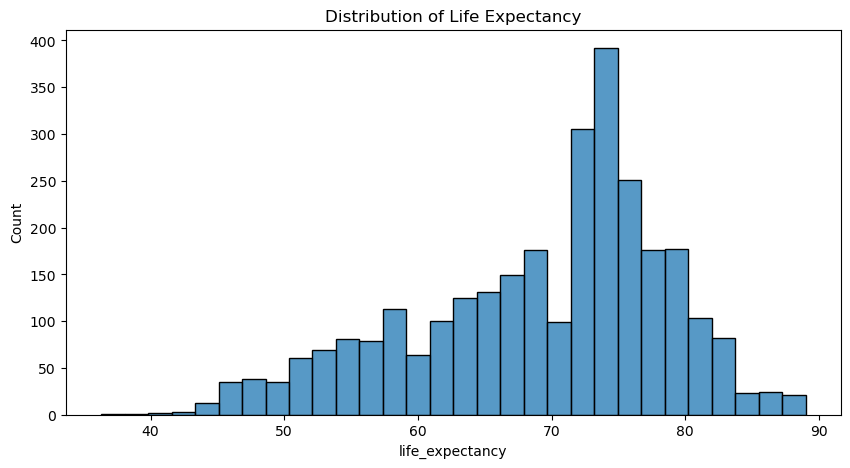

In [39]:
# Create a new figure with a specified size
plt.figure(figsize=(10, 5))

# Generate a histogram for the 'life_expectancy' column using seaborn
sns.histplot(df['life_expectancy'], bins=30)

# Set the title of the plot
plt.title('Distribution of Life Expectancy')

# Display the plot
plt.show()

### 5.2 Loop through each of our numeric fields and plot the distribution

We can then plot histograms for each other numerical variable in our dataset.

The purpose of creating these histograms is to understand the distribution of each numerical variable in our dataset. By visualising the data, we can easily identify characteristics such as the range of values, central tendency, mode, and the presence of any outliers. This is a crucial step in exploratory data analysis as it helps us understand the underlying structure of the data, and informs any preprocessing steps we might need to take before using this data for machine learning.

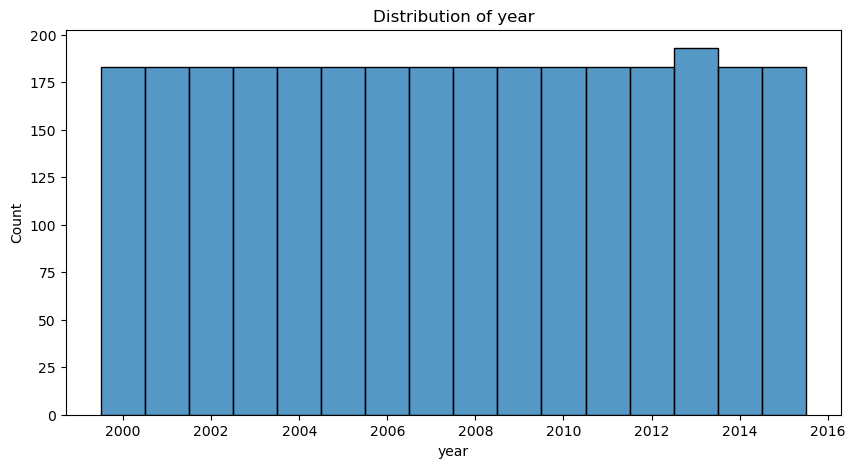

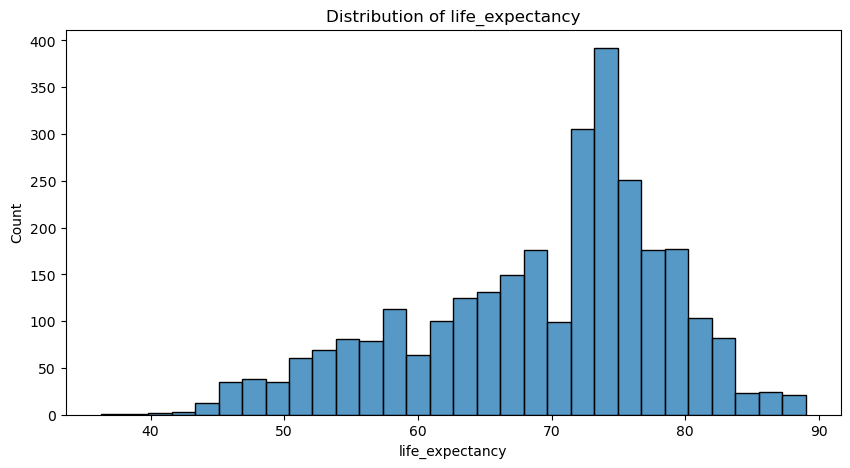

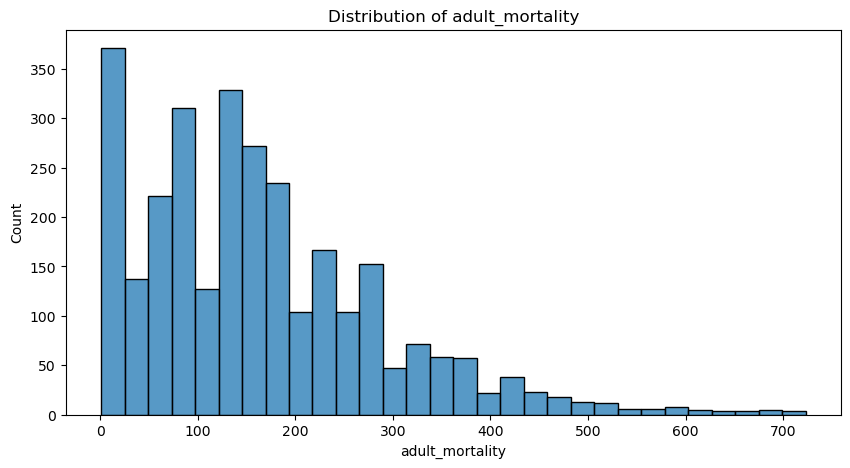

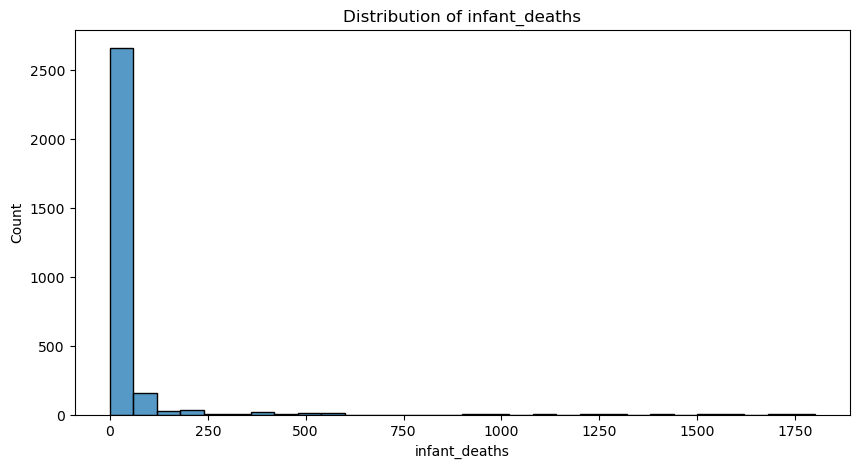

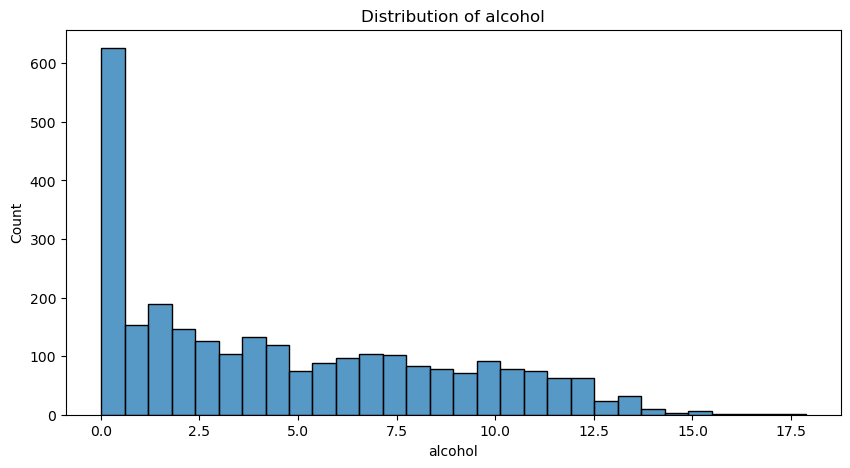

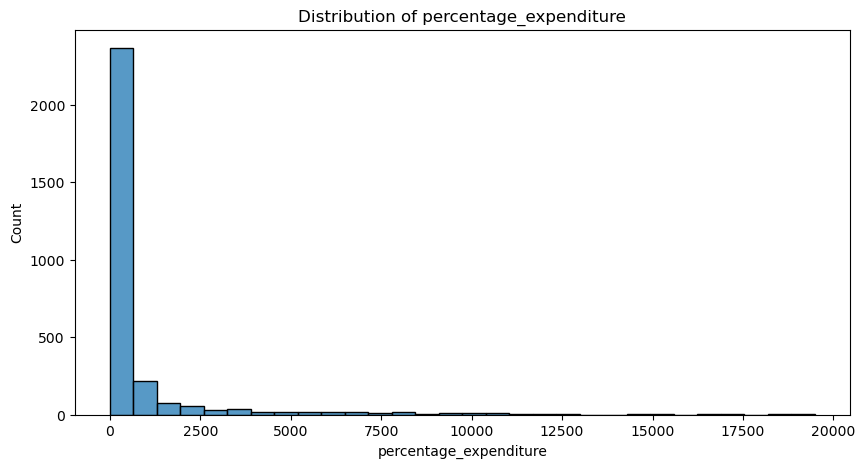

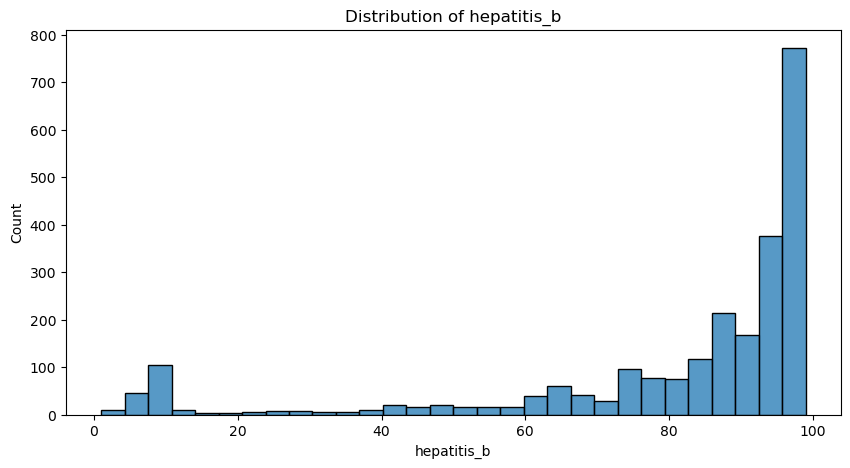

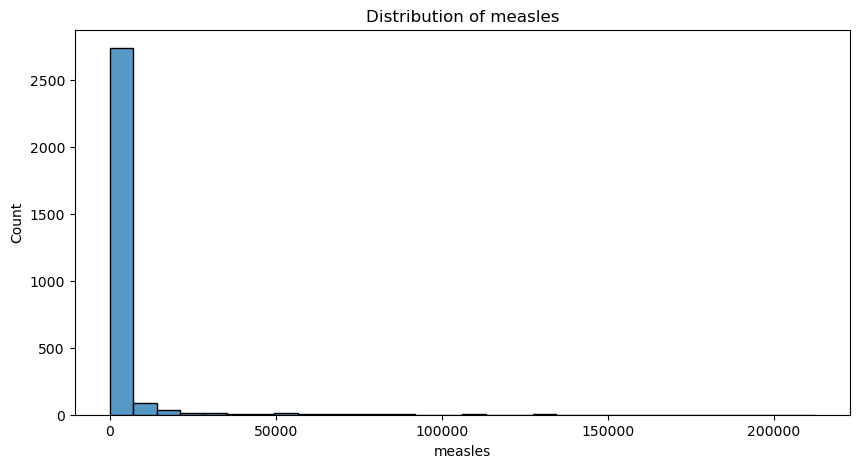

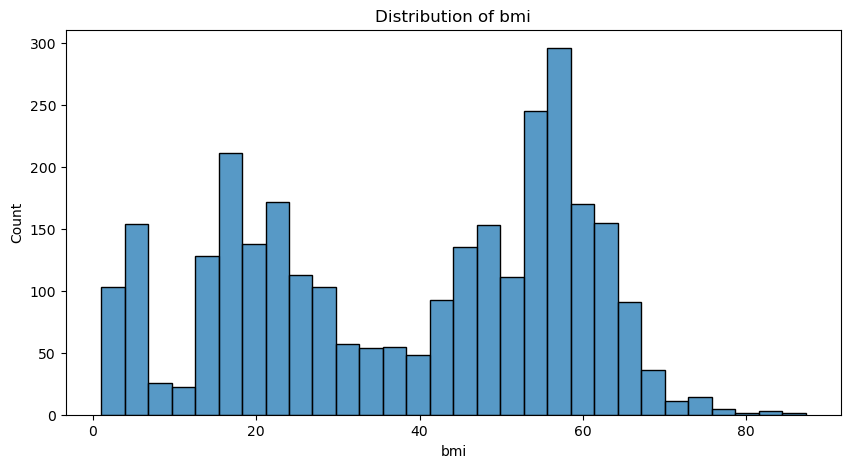

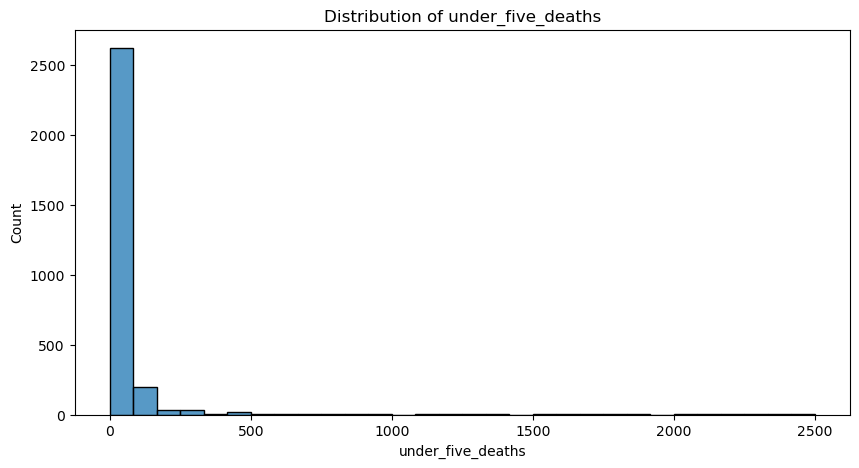

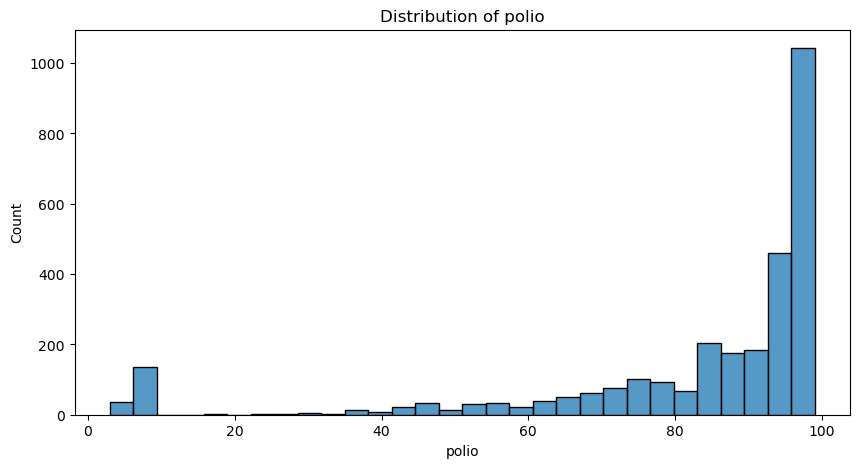

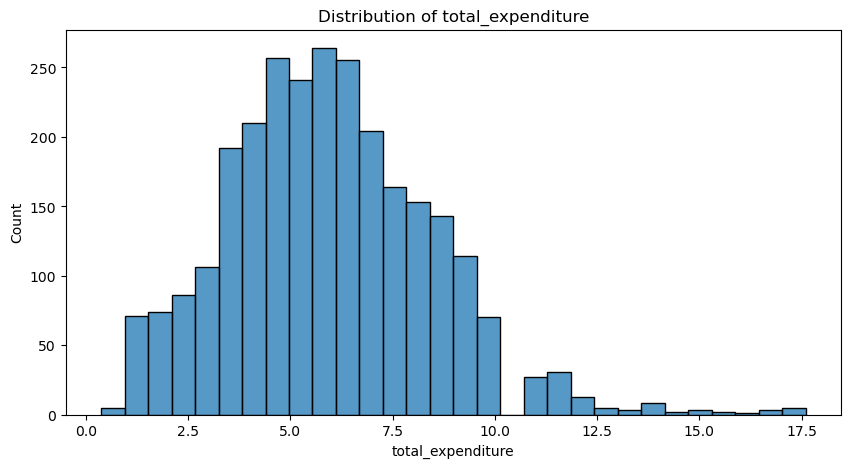

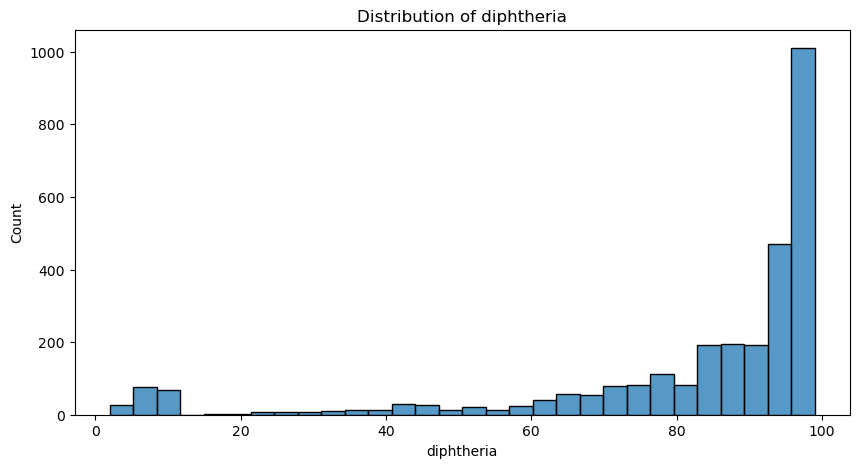

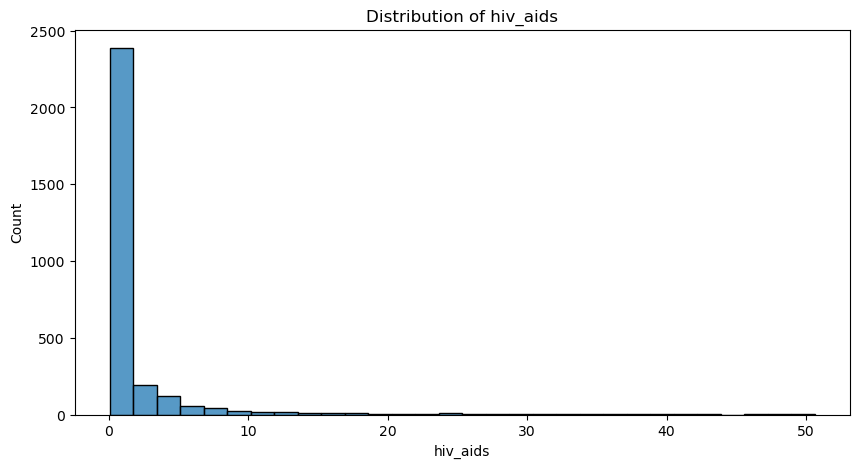

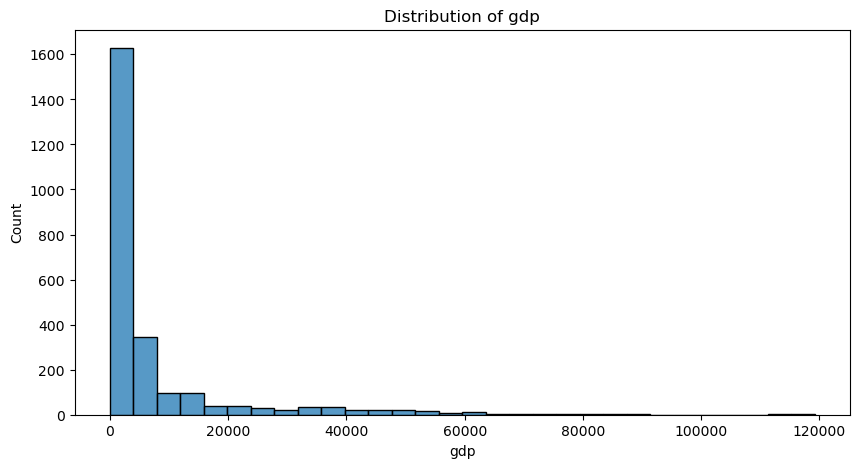

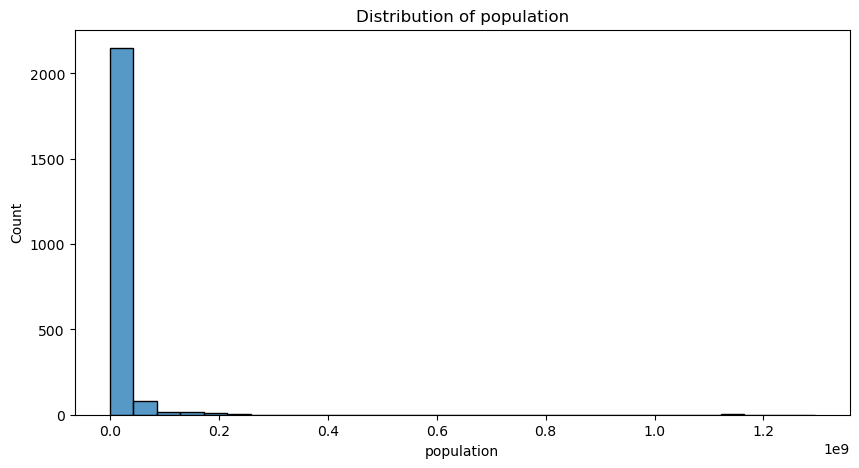

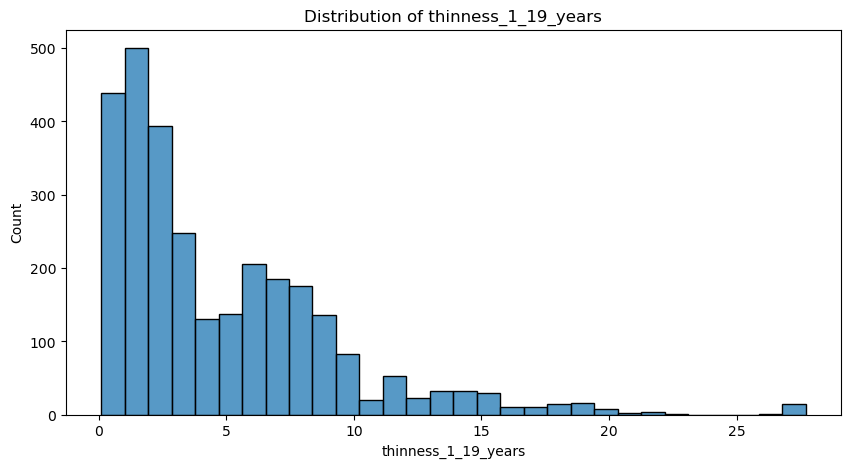

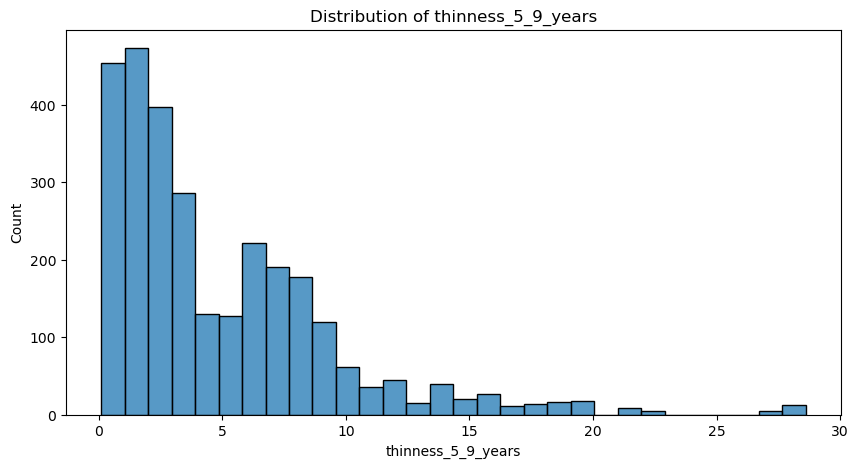

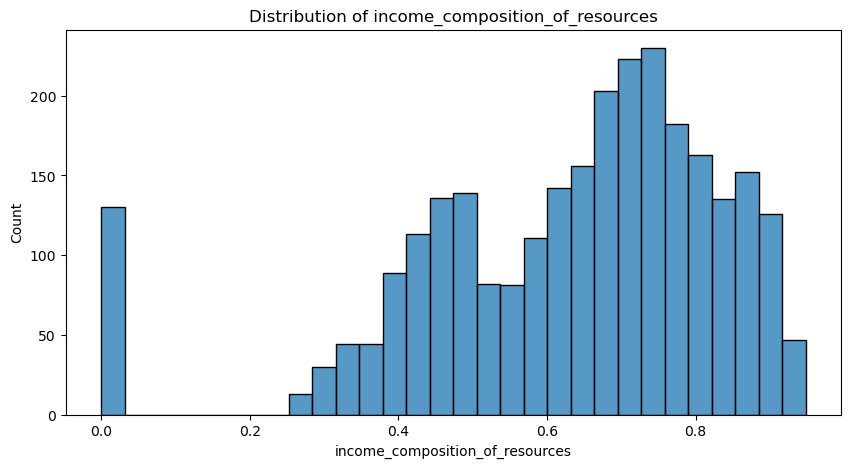

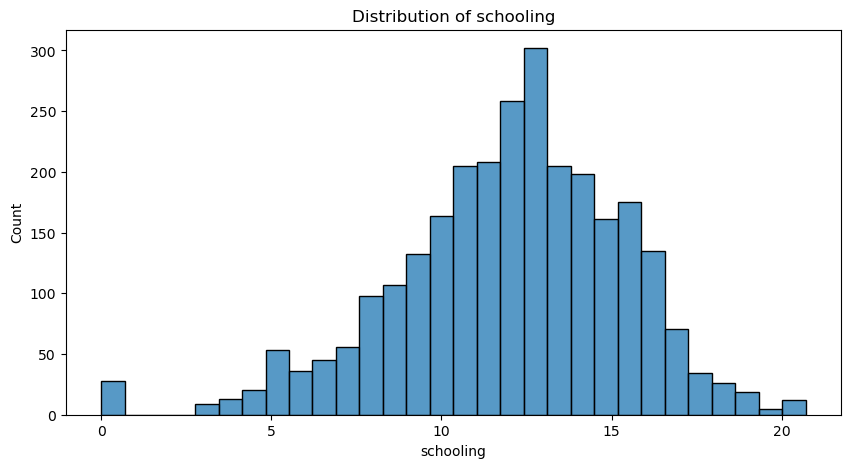

In [40]:
# Loop through each numerical variable
for var in num_vars:
    # Create a new figure with a specified size
    plt.figure(figsize=(10, 5))
    
    # Generate a histogram for the current variable using seaborn
    sns.histplot(df[var], bins=30)
    
    # Set the title of the plot to be 'Distribution of {variable name}'
    plt.title(f'Distribution of {var}')
    
    # Display the plot
    plt.show()

## 5.3 Plot categorical variables

### Plot frequency for 'status'

This indicates that there are far more records for developing countries in the dataset than developed. 

This is likely ok, as there are most likely a much larger number of developing countries in the world than developed, and the distribution matches what we would expect in reality.

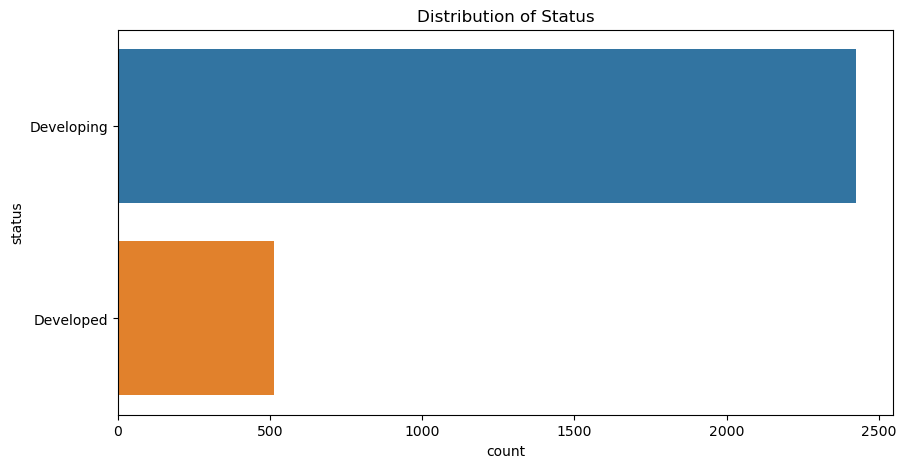

In [66]:
# Create a new figure with a specified size
plt.figure(figsize=(10, 5))

# Generate a vertical bar plot for the 'status' column using seaborn
sns.countplot(y='status', data=df)

# Set the title of the plot
plt.title('Distribution of Status')

# Display the plot
plt.show()

### Plot frequency for 'year'

This helps us see if a consistent number of records exist across all years present in the data

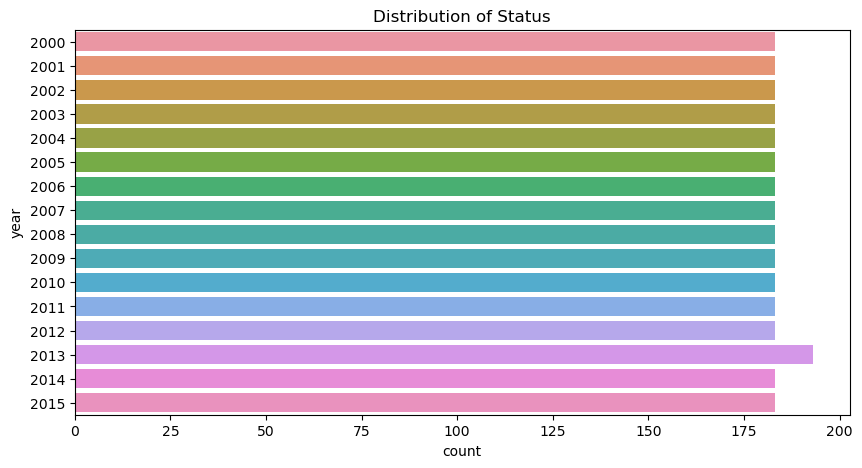

In [67]:
# Create a new figure with a specified size
plt.figure(figsize=(10, 5))

# Generate a vertical bar plot for the 'status' column using seaborn
sns.countplot(y='year', data=df)

# Set the title of the plot
plt.title('Distribution of Status')

# Display the plot
plt.show()

### Plot frequency plot for 'country'

Note this will produce a tall chart since there are many countries.

This can be useful to determine:

-  **Distribution of data across countries**: If some bars are significantly larger than others, it indicates that those countries have more records in your dataset.


-  **Data imbalance**: If the distribution of records is heavily skewed towards certain countries, this could indicate a data imbalance, which might affect the performance of any machine learning models trained on this data.

The specific conclusions you can draw will depend on the context of your data and what you're using it for.

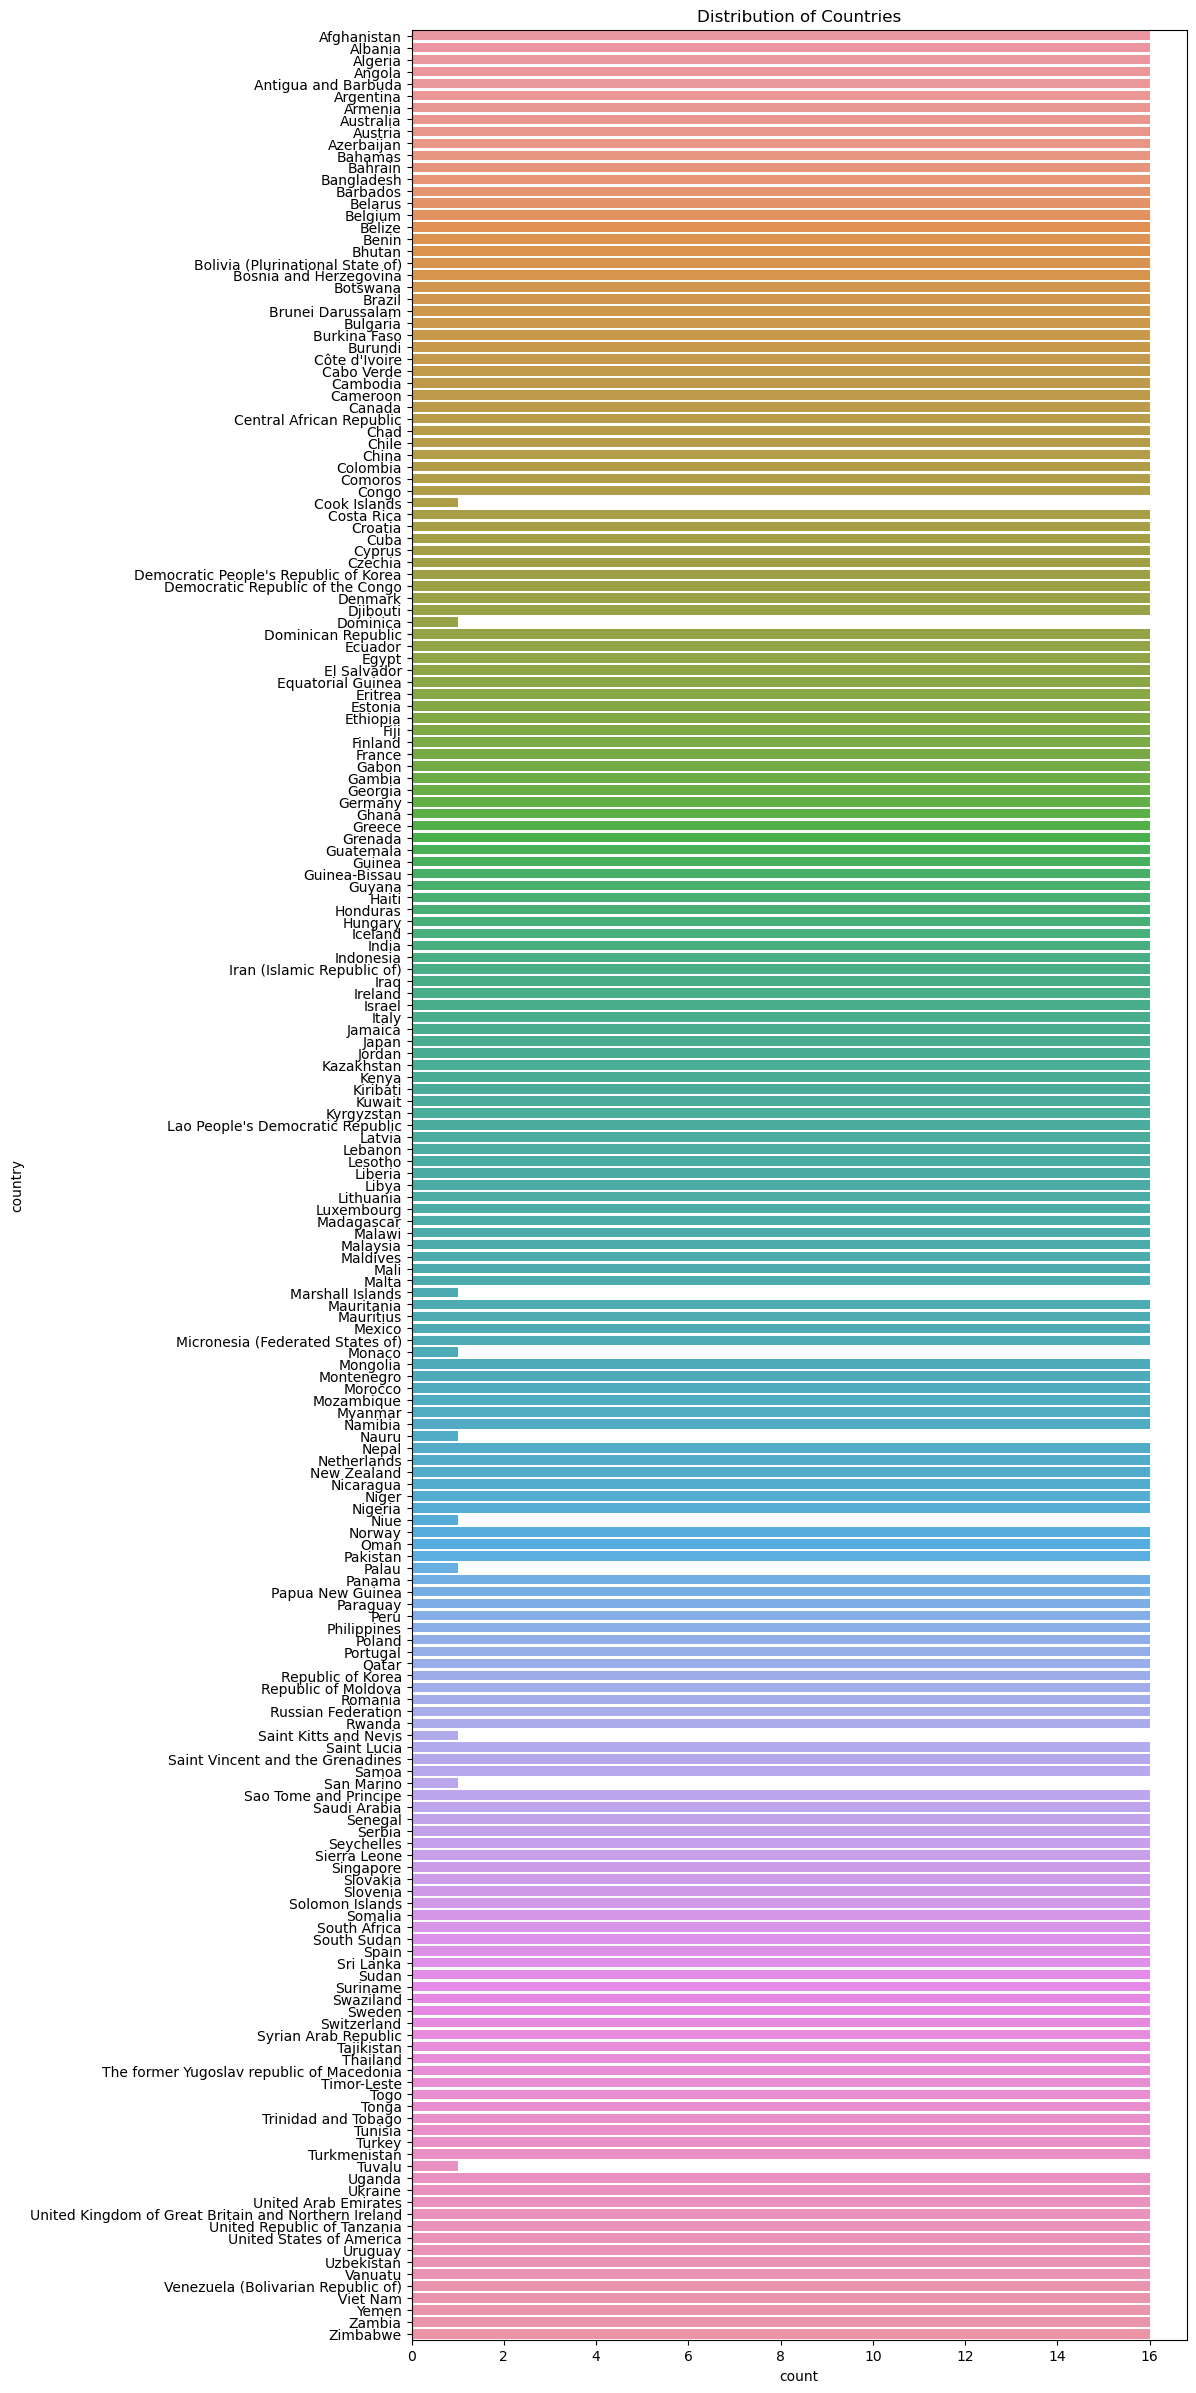

In [44]:
# Plot frequency plot for 'country'
# # Note this will produce a tall chart since there are many countries

# Create a new figure with a specified size
plt.figure(figsize=(10, 30))

# Generate a vertical bar plot for the 'country' column
sns.countplot(y='country', data=df)

# Set the title of the plot
plt.title('Distribution of Countries')

# Display the plot
plt.show()

# 6. Understand relationships between variables (Bivatiate analysis)

After examining our features individually, we can explore the relationships between pairs of features. This bivariate analysis can help uncover relationships and correlations between variables, providing a basis for generating hypotheses for further analysis.


### 6.1 Correlations Between Features and Target

To understand the relationship between our features and the target outcome, we can calculate the correlation coefficient between the target and each feature.

By plotting these correlation coefficients in a bar chart, we can visually assess which features have a strong relationship with the target. This is an important step in feature selection, as it helps us identify which features are most likely to be predictive of the target outcome. 

This and can help select the most relevant features for our predictive model.

C:\Users\hjurz\AppData\Local\Temp\ipykernel_32076\1416312483.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations = df.corr()['life_expectancy'].drop('life_expectancy')


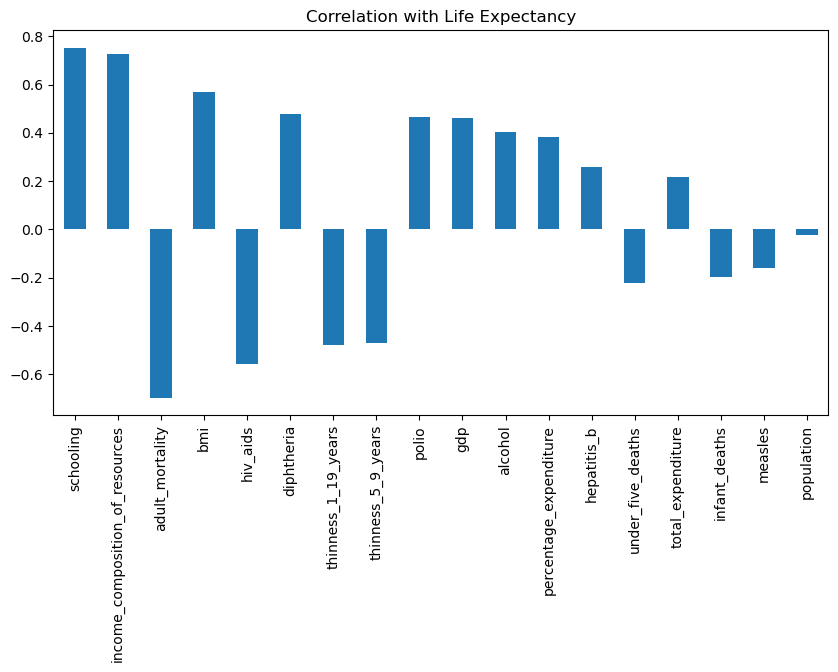

In [45]:
# Calculate the correlation coefficients between 'life_expectancy' and all other features
correlations = df.corr()['life_expectancy'].drop('life_expectancy')

# Sort the correlations in descending order of their absolute values
correlations = correlations.reindex(correlations.abs().sort_values(ascending=False).index)

# Create a new figure with a specified size
plt.figure(figsize=(10, 5))

# Generate a bar chart of the sorted correlation coefficients
correlations.plot(kind='bar')

# Set the title of the plot
plt.title('Correlation with Life Expectancy')

# Display the plot
plt.show()


**Caveat**

While correlation is a useful tool for identifying potential relationships between variables, it's important to note that a high correlation does not necessarily mean that a variable will be an important predictor in our model. 

Here's why (skip this if it's too complicated for now):

1. **Correlation does not imply causation**: Just because two variables move together does not mean that one causes the other. There could be an underlying factor that influences both variables.

2. **Linear dependency**: Correlation measures the linear relationship between two variables. However, the relationship between variables in real-world data can often be non-linear, which correlation might not capture effectively.

3. **Multicollinearity**: If two features are highly correlated with each other, including both in our model could lead to multicollinearity, which can make the model unstable and the estimates of the coefficients unreliable.

4. **Overfitting**: Including a feature just because it's highly correlated with the target could lead to overfitting, where the model performs well on the training data but poorly on unseen data.

Therefore, while correlation can guide feature selection, it's also important to consider other factors and use domain knowledge when building our model.

## 6.2 Correlations between other features

Examining correlations between features can provide valuable insights:

- **Identify Relationships**: Correlations can help identify linear relationships between different features.
- **Multicollinearity Detection**: High correlation between two features may indicate multicollinearity, which can affect model performance.
- **Feature Selection**: Understanding inter-feature relationships can inform feature selection, helping to choose non-redundant features that capture most of the information.

#### Correlation Heatmap

A correlation heatmap provides a visual representation of the correlations between pairs of variables/features, where each cell's color indicates the correlation strength and direction between two variables. This can help:

- **Visualise Relationships**: Heatmaps make it easier to identify patterns and relationships between variables.
- **Detect Multicollinearity**: Heatmaps can help spot highly correlated features, indicating potential multicollinearity.
- **Inform Feature Selection**: By identifying groups of correlated features, we can select representative features from each group, reducing redundancy.

This is a good initial step to understand relationships between variables

Note that this will only include numeric variables unless we perform one-hot-encoding.

C:\Users\hjurz\AppData\Local\Temp\ipykernel_32076\3969938681.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


<Axes: >

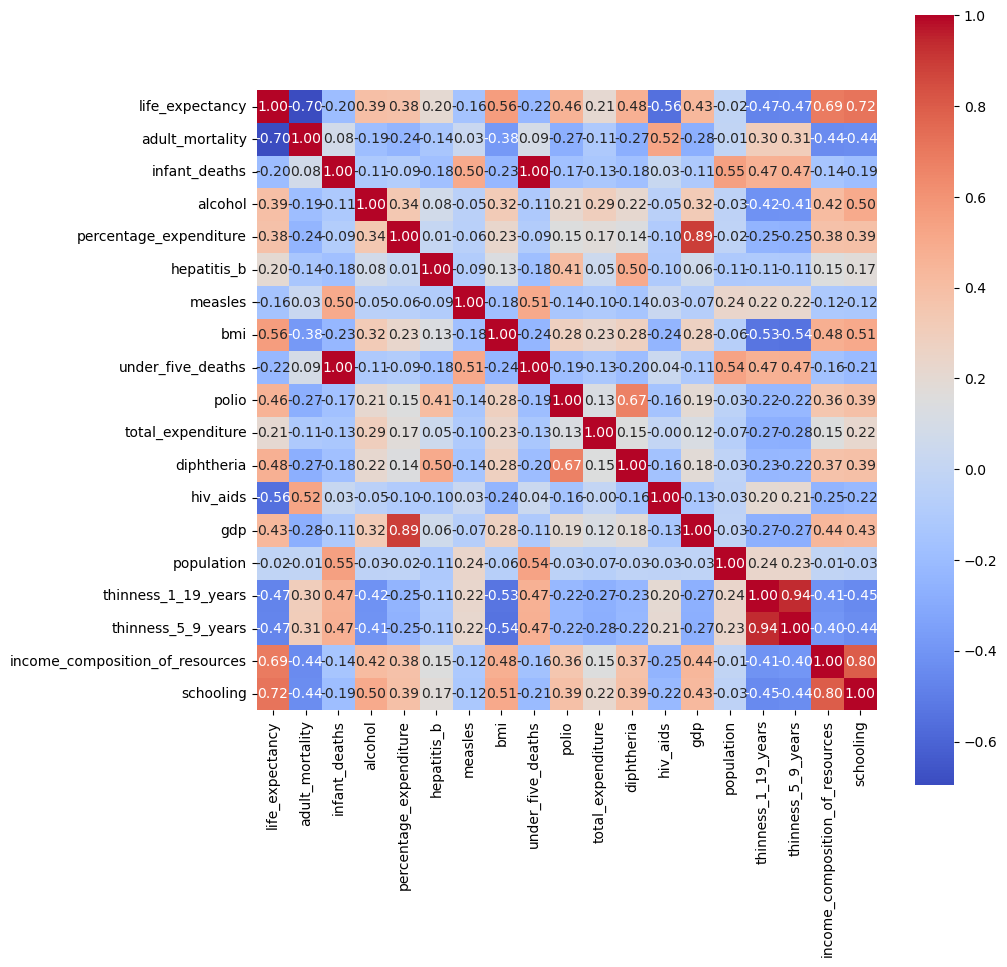

In [69]:
# Calculate the correlation matrix
corr = df.corr()

# Create a new figure with a specified size
plt.figure(figsize=(10, 10))

# Generate a heatmap for the correlation matrix using seaborn
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)

# Display the 

#### Pairplot

A pairplot is a matrix of scatterplots that allows you to see both the distribution of single variables and relationships between two variables. 

- Each row and column of the pairplot corresponds to a variable in your dataset, and every cell in the grid is a scatterplot of two variables. 

- The diagonal of this matrix shows the distribution of the variable corresponding to that row or column.

- This way, we can quickly see how variables are related, and identify any potential trends, patterns, or outliers. This can be particularly useful when we want to understand how our variables interact with each other, and can help inform feature selection and model building.

In this case it might not be efficient to use a pairplot, as we have a large number of features, but it can serve us as an initial step.

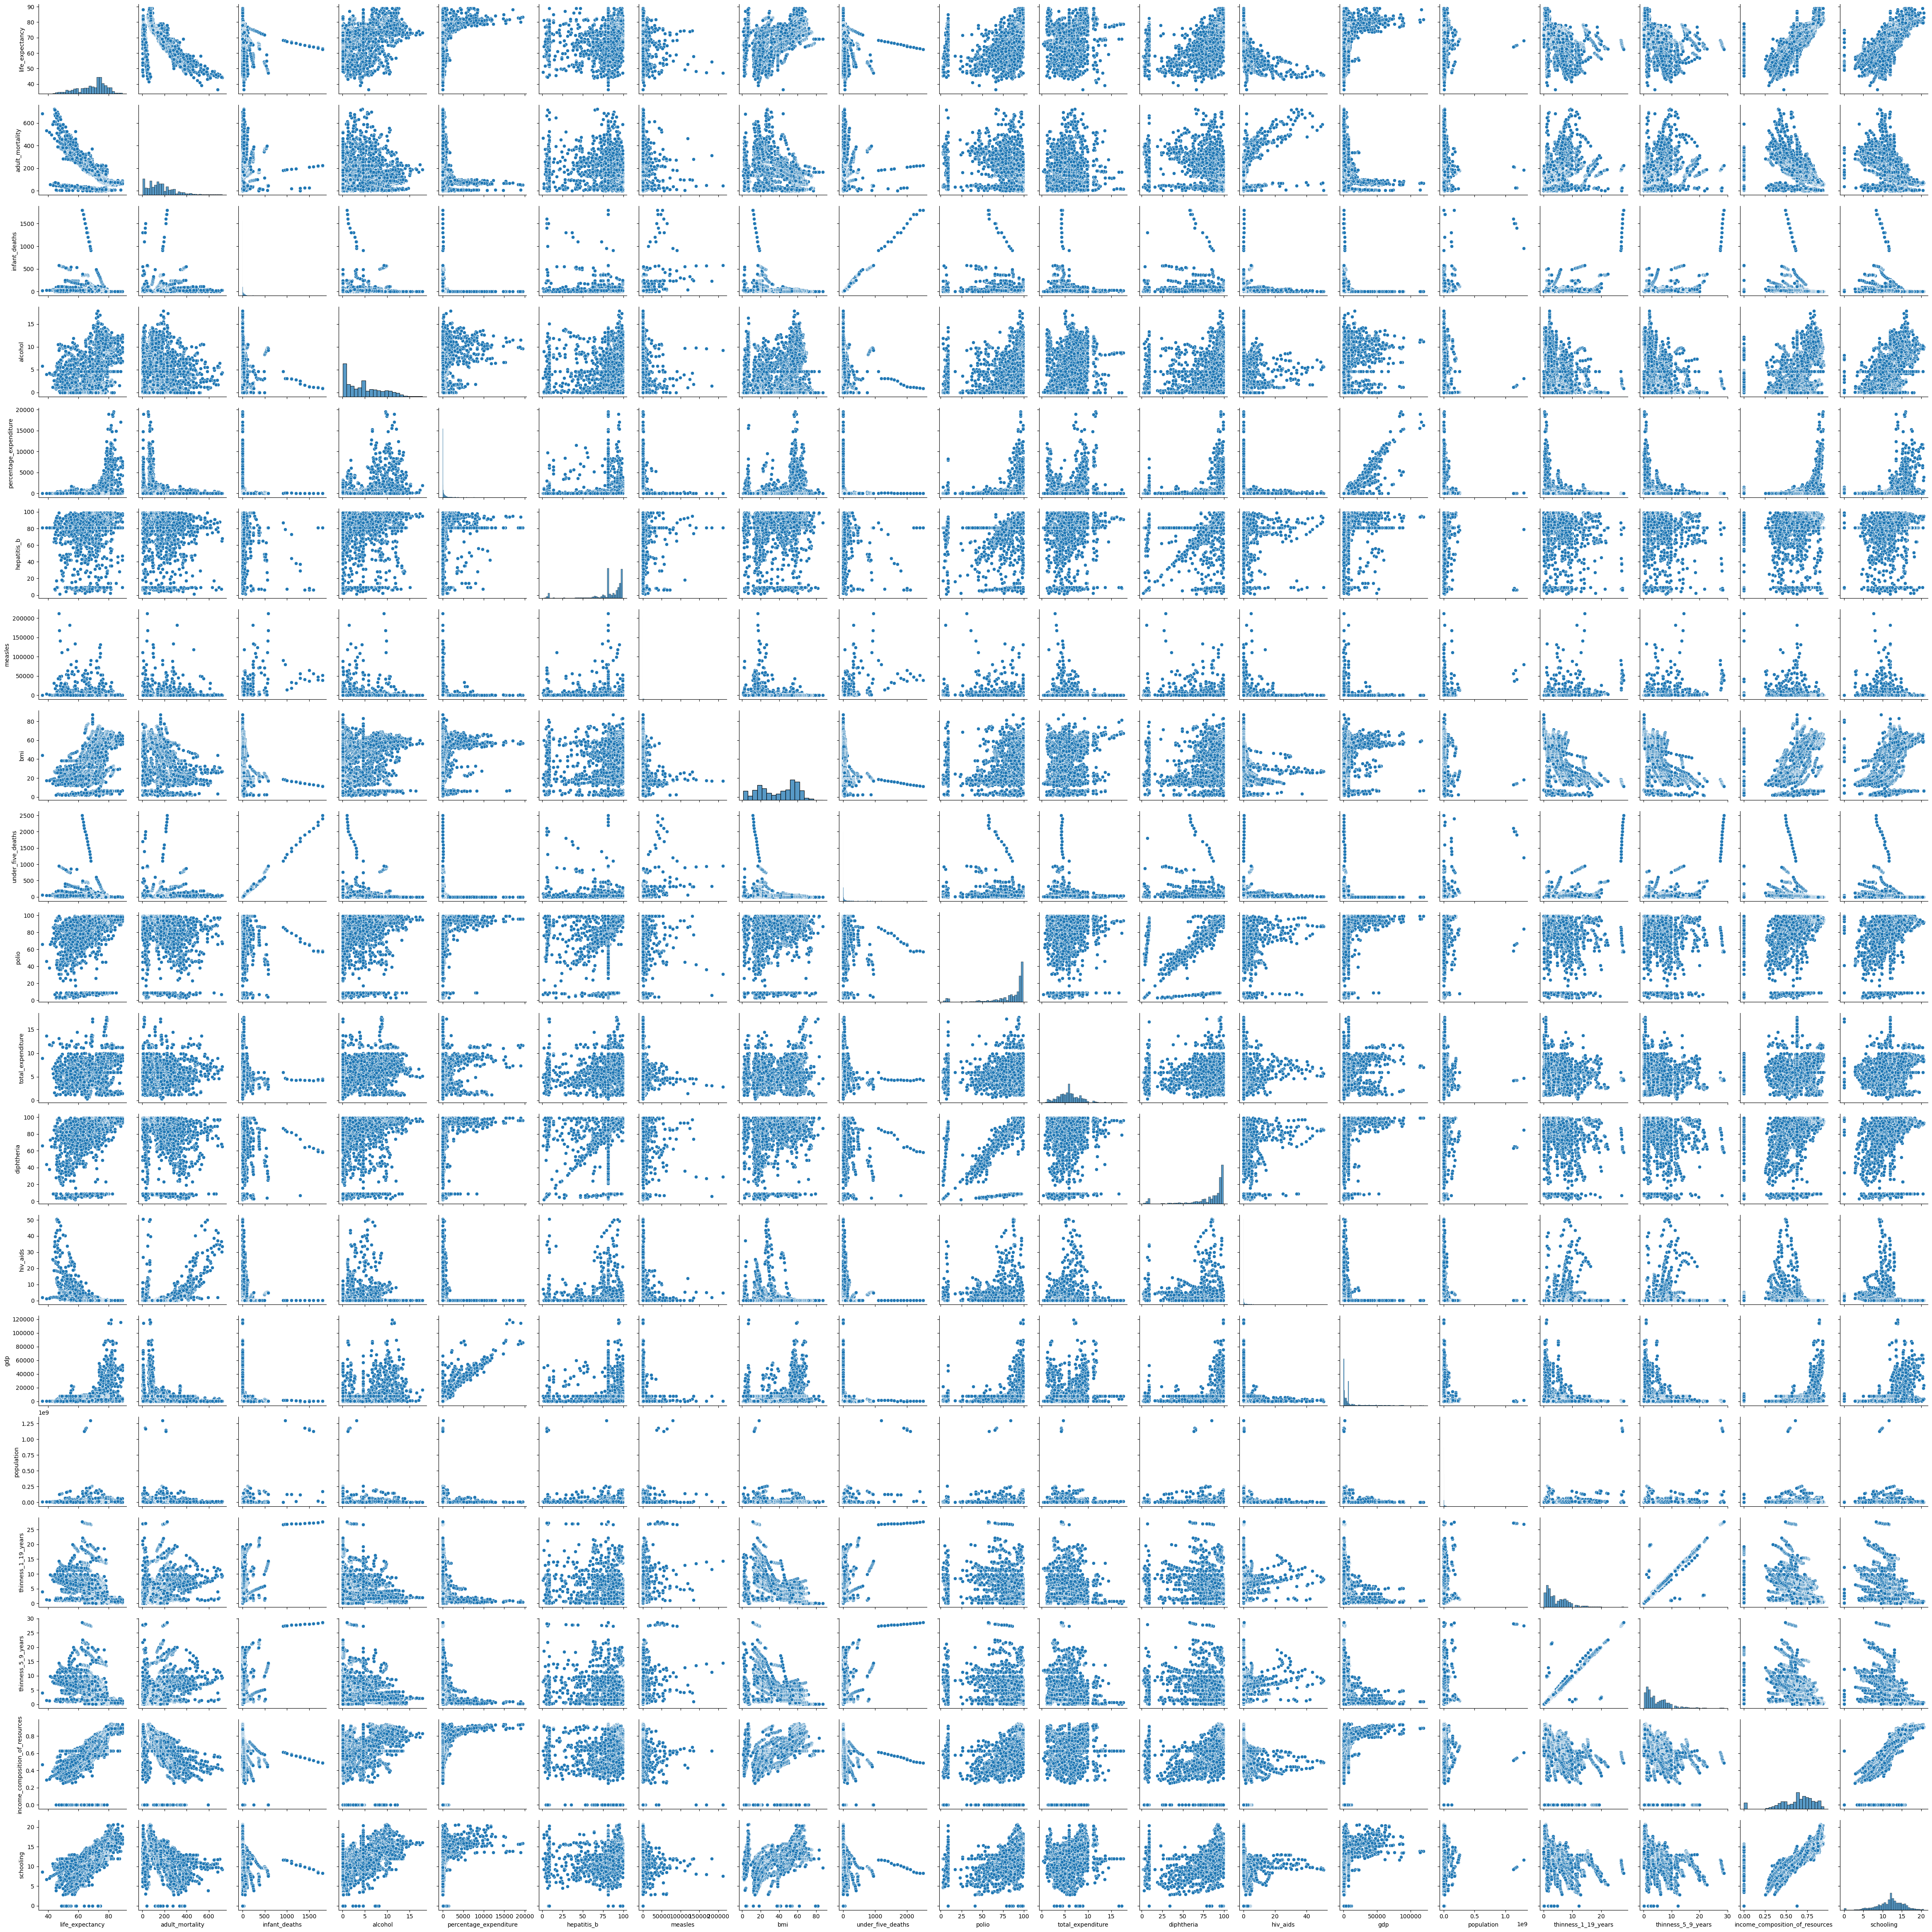

In [70]:
# Generate a pairplot for the DataFrame using seaborn
sns.pairplot(df)

# Display the plot
plt.show()

## Conclusion

This notebook provided an exploratory data analysis of a life expectancy dataset. 

We've loaded the data, understood its structure, categorised and identified key features, assessed data quality, and performed both univariate and bivariate analysis. 
This process has allowed us to gain a deeper understanding of the data and prepare it for further analysis or modeling.

## Further EDA Considerations

EDA can also include many other tasks depending on the specifics of your project. Here are a few additional tasks that could be considered:

1. **Outlier Detection**: Identifying and handling outliers in your dataset. Outliers can significantly impact the results of your analysis and the performance of your model.
4. **Statistical Tests**: Conducting statistical tests to understand the relationships between variables. For example, you might use a t-test to compare the means of two groups, or a chi-squared test to understand the relationship between two categorical variables.
5. **Data Transformation**: Applying transformations to your data to meet the assumptions of your analysis or modeling technique. For example, you might apply a log transformation to a skewed variable to make it more normally distributed.

Remember, the specific tasks you include in your EDA will depend on the nature of your data and the specific goals of your project.